In [1]:
import ModelManager as mm_mod
import config_defaults as cd
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autotime

### Initializing the Model and Data pipes

In [23]:
reload(mm_mod)
reload(cd)
param_overrides = {'NGRAM_MODE': 'spacy'}
mm = mm_mod.ModelManager(hparams=param_overrides)
# mm = mm_mod.ModelManager(hparams=None)

2018-09-30 19:40:34,388 root         INFO     initialized model with hyperparametrs:
2018-09-30 19:40:34,389 root         INFO     LR: 0.01
2018-09-30 19:40:34,389 root         INFO     NEPOCH: 10
2018-09-30 19:40:34,389 root         INFO     BATCH_SIZE: 32
2018-09-30 19:40:34,390 root         INFO     NGRAM_SIZE: 2
2018-09-30 19:40:34,391 root         INFO     VOC_SIZE: 10000
2018-09-30 19:40:34,391 root         INFO     EMBEDDING_DIM: 100
2018-09-30 19:40:34,391 root         INFO     NGRAM_MODE: spacy
2018-09-30 19:40:34,392 root         INFO     VAL_SIZE: 5000
2018-09-30 19:40:34,392 root         INFO     OPTIMIZER: <class 'torch.optim.adam.Adam'>
2018-09-30 19:40:34,393 root         INFO     VAL_FREQ: 4
2018-09-30 19:40:34,393 root         INFO     REMOVE_STOP_WORDS: True
2018-09-30 19:40:34,393 root         INFO     REMOVE_PUNC: True
2018-09-30 19:40:34,394 root         INFO     EARLY_STOP: True
2018-09-30 19:40:34,394 root         INFO     EARLY_STOP_LOOKBACK: 2
2018-09-30 19:40:

### Comparing SpaCy to Naive

In [25]:
mm.load_data()
mm.data_to_pipe()

2018-09-30 19:40:35,970 root         INFO     found pickle files in ./data/pickles/, loading them instead of rebuilding ... 
2018-09-30 19:40:39,113 root         INFO     constructing ngram_indexer ...
2018-09-30 19:40:39,118 root         INFO     indexer length 20000



2018-09-30 19:40:41,193 root         INFO     setting each dataset's token indexes



2018-09-30 19:40:41,809 root         INFO     setting each dataset's token indexes



time: 6.79 s


### Trying to find a good LR

In [26]:
lr_list_exp_neg = np.arange(1,6)
lr_list_neg = 1 / np.power(10, lr_list_exp_neg)
lr_list_exp_pos = np.arange(0,3)
lr_list_pos = np.power(10, lr_list_exp_pos)

lr_list = np.append(lr_list_neg, lr_list_pos)
lr_list.sort()
print(lr_list)

[1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02]
time: 1.51 ms


In [27]:
# training all of these through 1 epoch and seeing results
mm.res_df = None  # reset the results dataframe
for cur_lr in lr_list:
    # overriding some hyperparameters
    param_overrides = {'LR': cur_lr,
                       'EARLY_STOP': False}
    mm.hparams.update(param_overrides)
    mm.train(epoch_override=1, reload_data=False)  
display(mm.res_df)

2018-09-30 19:40:50,475 root         INFO     Epoch: [1/10], Step: [128/625], Validation Acc: 54.48
2018-09-30 19:40:51,314 root         INFO     Epoch: [1/10], Step: [256/625], Validation Acc: 54.8
2018-09-30 19:40:52,145 root         INFO     Epoch: [1/10], Step: [384/625], Validation Acc: 54.94
2018-09-30 19:40:52,973 root         INFO     Epoch: [1/10], Step: [512/625], Validation Acc: 54.98

2018-09-30 19:40:53,463 root         INFO     generating new pandas dataframe to store results


2018-09-30 19:40:55,254 root         INFO     Epoch: [1/10], Step: [128/625], Validation Acc: 50.18
2018-09-30 19:40:56,089 root         INFO     Epoch: [1/10], Step: [256/625], Validation Acc: 54.64
2018-09-30 19:40:56,921 root         INFO     Epoch: [1/10], Step: [384/625], Validation Acc: 56.3
2018-09-30 19:40:57,764 root         INFO     Epoch: [1/10], Step: [512/625], Validation Acc: 58.92

2018-09-30 19:40:58,258 root         INFO     appending new results to existing dataframe


2018-09-30 19:40:59,992 root         INFO     Epoch: [1/10], Step: [128/625], Validation Acc: 60.9
2018-09-30 19:41:00,810 root         INFO     Epoch: [1/10], Step: [256/625], Validation Acc: 64.16
2018-09-30 19:41:01,636 root         INFO     Epoch: [1/10], Step: [384/625], Validation Acc: 71.54
2018-09-30 19:41:02,459 root         INFO     Epoch: [1/10], Step: [512/625], Validation Acc: 72.38

2018-09-30 19:41:02,942 root         INFO     appending new results to existing dataframe


2018-09-30 19:41:04,772 root         INFO     Epoch: [1/10], Step: [128/625], Validation Acc: 82.78
2018-09-30 19:41:05,604 root         INFO     Epoch: [1/10], Step: [256/625], Validation Acc: 86.24
2018-09-30 19:41:06,426 root         INFO     Epoch: [1/10], Step: [384/625], Validation Acc: 86.7
2018-09-30 19:41:07,320 root         INFO     Epoch: [1/10], Step: [512/625], Validation Acc: 86.78

2018-09-30 19:41:07,842 root         INFO     appending new results to existing dataframe


2018-09-30 19:41:09,664 root         INFO     Epoch: [1/10], Step: [128/625], Validation Acc: 84.32
2018-09-30 19:41:10,491 root         INFO     Epoch: [1/10], Step: [256/625], Validation Acc: 85.34
2018-09-30 19:41:11,355 root         INFO     Epoch: [1/10], Step: [384/625], Validation Acc: 86.76
2018-09-30 19:41:12,243 root         INFO     Epoch: [1/10], Step: [512/625], Validation Acc: 87.4

2018-09-30 19:41:12,752 root         INFO     appending new results to existing dataframe


2018-09-30 19:41:14,510 root         INFO     Epoch: [1/10], Step: [128/625], Validation Acc: 72.72
2018-09-30 19:41:15,343 root         INFO     Epoch: [1/10], Step: [256/625], Validation Acc: 83.06
2018-09-30 19:41:16,242 root         INFO     Epoch: [1/10], Step: [384/625], Validation Acc: 81.04
2018-09-30 19:41:17,103 root         INFO     Epoch: [1/10], Step: [512/625], Validation Acc: 82.16

2018-09-30 19:41:17,599 root         INFO     appending new results to existing dataframe


2018-09-30 19:41:19,314 root         INFO     Epoch: [1/10], Step: [128/625], Validation Acc: 75.24
2018-09-30 19:41:20,139 root         INFO     Epoch: [1/10], Step: [256/625], Validation Acc: 81.0
2018-09-30 19:41:20,965 root         INFO     Epoch: [1/10], Step: [384/625], Validation Acc: 70.72
2018-09-30 19:41:21,861 root         INFO     Epoch: [1/10], Step: [512/625], Validation Acc: 79.78

2018-09-30 19:41:22,370 root         INFO     appending new results to existing dataframe


2018-09-30 19:41:24,279 root         INFO     Epoch: [1/10], Step: [128/625], Validation Acc: 64.4
2018-09-30 19:41:25,166 root         INFO     Epoch: [1/10], Step: [256/625], Validation Acc: 68.68
2018-09-30 19:41:26,094 root         INFO     Epoch: [1/10], Step: [384/625], Validation Acc: 70.5
2018-09-30 19:41:26,940 root         INFO     Epoch: [1/10], Step: [512/625], Validation Acc: 82.76

2018-09-30 19:41:27,515 root         INFO     appending new results to existing dataframe


,initial_val_acc,epoch1_val_acc,epoch2_val_acc,epoch3_val_acc,final_val_acc,training_time,total_data_iterated,early_stopped,pct_unk_train,pct_unk_val,...,EMBEDDING_DIM,NGRAM_MODE,VAL_SIZE,OPTIMIZER,VAL_FREQ,REMOVE_STOP_WORDS,REMOVE_PUNC,EARLY_STOP,EARLY_STOP_LOOKBACK,EARLY_STOP_MIN_IMPROVE
1,,,,,54.98,4.57,20000,False,0.530094,0.534054,...,100,spacy,5000,<class 'torch.optim.adam.Adam'>,4,True,True,False,2,0.01
2,,,,,58.92,4.51,20000,False,0.530094,0.534054,...,100,spacy,5000,<class 'torch.optim.adam.Adam'>,4,True,True,False,2,0.01
3,,,,,72.38,4.4,20000,False,0.530094,0.534054,...,100,spacy,5000,<class 'torch.optim.adam.Adam'>,4,True,True,False,2,0.01
4,,,,,86.78,4.62,20000,False,0.530094,0.534054,...,100,spacy,5000,<class 'torch.optim.adam.Adam'>,4,True,True,False,2,0.01
5,,,,,87.40,4.61,20000,False,0.530094,0.534054,...,100,spacy,5000,<class 'torch.optim.adam.Adam'>,4,True,True,False,2,0.01
6,,,,,82.16,4.55,20000,False,0.530094,0.534054,...,100,spacy,5000,<class 'torch.optim.adam.Adam'>,4,True,True,False,2,0.01
7,,,,,79.78,4.49,20000,False,0.530094,0.534054,...,100,spacy,5000,<class 'torch.optim.adam.Adam'>,4,True,True,False,2,0.01
8,,,,,82.76,4.82,20000,False,0.530094,0.534054,...,100,spacy,5000,<class 'torch.optim.adam.Adam'>,4,True,True,False,2,0.01


time: 38.9 s


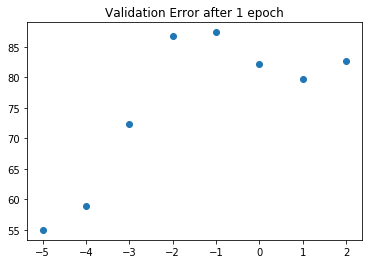

time: 68 ms


In [28]:
plt.scatter(np.log10(mm.res_df['LR']), mm.res_df['final_val_acc'])
plt.title('Validation Error after 1 epoch')
plt.show()

In [17]:
mm.res_df[['pct_unk_val']]

,pct_unk_val
1,
2,
3,
4,
5,
6,
7,
8,


time: 20.7 ms
